In [78]:
# Task: Stacked autoencoder (with 3 autoencoders) based pre-training of a DFNN 
# based classifier for Image dataset 3
# • Model of AANN: 5-layer structure
# • Mode of learning for AANNs: Mini-batch mode
# • Stopping criterion: Change in average error below a threshold
# • Weight update rule: AdaM
# • Report should include the confusion matrices for training data and test data, for (a) 
# DFNN trained using only labeled data, (b) DFNN using a stacked autoencoder
# pretrained using unlabeled data and finetuned using labeled data. DFNN 
# configuration should be the same in both (a) and (b).

# You can use Pytorch as well. No need to implement neural network from scratch.
# You can use any library for plotting the graphs.

# Dataset:
# it is in ./task3 {folder}
# the {folder} has 4 files
# testing_data_set_4
# training_data_set_4_labeled
# training_data_set_4_unlabeled
# validation_data_set_4

# Train data labeled -> (750, 37)
# Train data unlabeled -> (1750, 36)
# Validation data -> (250, 37)
# Test data -> (250, 37)

In [79]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")


In [80]:
folder = 'task3'

def seed_all(seed=59+87+122+143):
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

In [81]:
class DataLoader:
    def __init__(self, train_data_labeled_path, train_data_unlabeled_path, test_data_path, val_data_path):
        self.train_data_labeled_features, self.train_data_labeled_labels = self.load_data(train_data_labeled_path)
        self.train_data_unlabeled = self.load_data(train_data_unlabeled_path)
        self.test_data_features, self.test_data_labels = self.load_data(test_data_path)
        self.val_data_features, self.val_data_labels = self.load_data(val_data_path)        

    def split_features_labels(self, data):
        features = data[:, :-1]
        labels = data[:, -1]
        return features, labels

    def load_data(self, data_path):
        data = pd.read_csv(data_path, header=None).values.astype(np.float32)
        # if columns of data are 36, then it is train_data_unlabeled
        # else split the data into features and labels
        if data.shape[1] == 36:
            return data
        else:
            return self.split_features_labels(data)
    
    def standardize_data(self):
        scaler = StandardScaler()
        self.train_data_labeled = scaler.fit_transform(self.train_data_labeled)
        self.train_data_unlabeled = scaler.transform(self.train_data_unlabeled)
        self.test_data = scaler.transform(self.test_data)
        self.val_data = scaler.transform(self.val_data)

    def convert_to_tensor(self):
        self.train_data_labeled = torch.tensor(self.train_data_labeled)
        self.train_data_unlabeled = torch.tensor(self.train_data_unlabeled)
        self.test_data = torch.tensor(self.test_data)
        self.val_data = torch.tensor(self.val_data)


In [82]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        # Total 5 layers -> input, 3 hidden, output in the whole network

        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),   # Linear activation for the input layer
            nn.Tanh(),                             # Tanh activation for the 1st hidden layer
            nn.Linear(hidden_dim[0], hidden_dim[1]) # Linear activation for the 2nd hidden layer
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim[1], hidden_dim[2]), # Linear activation for the 2nd hidden layer (shared layer)
            nn.Tanh(),                               # Tanh activation for the 3rd hidden layer
            nn.Linear(hidden_dim[2], input_dim)      # Linear activation for the output layer
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def train(self, train_data, criterion, optimizer, epochs, threshold, batch_size):
        train_losses = []
        for epoch in range(epochs):
            for i in range(0, len(train_data), batch_size):
                inputs = train_data[i:i+batch_size]
                outputs = self(inputs)
                loss = criterion(outputs, inputs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_losses.append(loss.item())
            if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < threshold:
                break
        return train_losses


In [83]:
class StackedAutoEncoder(nn.Module):
    # Stacked Autoencoder with 3 autoencoders
    def __init__(self, input_dim, hidden_dims):
        super(StackedAutoEncoder, self).__init__()
        self.autoencoders = nn.ModuleList([
            AutoEncoder(input_dim, hidden_dims) for i in range(3)
        ])

    def forward(self, x):
        for autoencoder in self.autoencoders:
            x = autoencoder(x)
        return x
    
    def pretrain(self, unlabeled_data, criterion, optimizer, epochs, threshold, batch_size):
        for autoencoder in tqdm(self.autoencoders, desc='Autoencoder'):
            autoencoder.train(unlabeled_data, criterion, optimizer, epochs, threshold, batch_size)


In [84]:
class DFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        # self.layers.append(nn.Tanh())
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
         


In [85]:
class DFNNClassifier:
    def __init__(self, model, criterion, optimizer, epochs, threshold, batch_size):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.threshold = threshold
        self.batch_size = batch_size

    def train(self, train_data, train_labels):
        train_errors = []
        train_accuracies = []
        for epoch in tqdm(range(self.epochs), desc="DFNN Training", unit="epoch"):
            self.model.train()
            epoch_loss = 0
            correct = 0
            total = 0
            for i in range(0, train_data.shape[0], self.batch_size):
                data = train_data[i:i + self.batch_size]
                labels = train_labels[i:i + self.batch_size]
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
            train_errors.append(epoch_loss / (train_data.shape[0] / self.batch_size))
            train_accuracies.append(correct / total)

            if epoch > 0 and abs(train_errors[-1] - train_errors[-2]) < self.threshold:
                print(f"Converged at epoch {epoch}")
                break
                
        return train_errors, train_accuracies
    
    def evaluate(self, data, labels):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)
            predictions = torch.argmax(outputs, dim=1)
            accuracy = (predictions == labels).sum().item() / labels.size(0)
        return loss.item(), accuracy, predictions
    
    def confusion_matrix_train(self, train_data, train_labels):
        self.model.eval()
        outputs = self.model(train_data)
        predictions = torch.argmax(outputs, dim=1)
        cm = confusion_matrix(train_labels, predictions.detach().numpy())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{self.optimizer_name} Confusion Matrix (Train)")
        plt.axis('equal')
        plt.savefig(f"{folder}/{self.optimizer_name}_confusion_matrix_train.pdf", format="pdf", bbox_inches="tight")
        return cm
    
    def confusion_matrix_test(self, test_data, test_labels):
        self.model.eval()
        outputs = self.model(test_data)
        predictions = torch.argmax(outputs, dim=1)
        cm = confusion_matrix(test_labels, predictions.detach().numpy())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{self.optimizer_name} Confusion Matrix (Test)")
        plt.axis('equal')
        plt.savefig(f"{folder}/{self.optimizer_name}_confusion_matrix_test.pdf", format="pdf", bbox_inches="tight")
        return cm
    
    def plot_avg_train_error(self, train_errors):
        plt.plot(train_errors)
        plt.xlabel("Epoch")
        plt.ylabel("Average Error")
        plt.title(f"{self.optimizer_name} Average Error on Training Data")
        plt.savefig(f"{folder}/{self.optimizer_name}_average_error.pdf", format="pdf", bbox_inches="tight")
        plt.show()

    def plot_avg_train_accuracy(self, train_accuracies):
        plt.plot(train_accuracies)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{self.optimizer_name} Accuracy on Training Data")
        plt.savefig(f"{folder}/{self.optimizer_name}_accuracy.pdf", format="pdf", bbox_inches="tight")
        plt.show()

    def plot_all(self, train_data, train_labels, test_data, test_labels):
        train_errors, train_accuracies = self.train(train_data, train_labels)
        loss, accuracy, predictions = self.evaluate(test_data, test_labels)
        print(f"{self.optimizer_name} Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
        self.plot_avg_train_error(train_errors)
        self.plot_avg_train_accuracy(train_accuracies)
        self.confusion_matrix_train(train_data, train_labels)
        self.confusion_matrix_test(test_data, test_labels)


In [86]:
# Class for Stacked Autoencoder Pretraining using Unlabeled Data and Fine-tuning using Labeled Data
class SAEClassifier:
    def __init__(self, stacked_autoencoder, dfnn_classifier, criterion, optimizer, epochs, threshold, batch_size):
        self.stacked_autoencoder = stacked_autoencoder
        self.dfnn_classifier = dfnn_classifier
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.threshold = threshold
        self.batch_size = batch_size

    # Pretraining using Stacked Autoencoder
    def pretrain_autoencoders(self, train_data_unlabeled):
        self.stacked_autoencoder.pretrain(train_data_unlabeled, self.criterion, self.optimizer, self.epochs, self.threshold, self.batch_size)

    # Fine-tuning using Labeled Data
    def fine_tune_classifier(self, train_data_labeled, train_labels):
        train_errors, train_accuracies = self.dfnn_classifier.train(train_data_labeled, train_labels)
        return train_errors, train_accuracies
    
    def evaluate(self, data, labels):
        loss, accuracy, predictions = self.dfnn_classifier.evaluate(data, labels)
        return loss, accuracy, predictions
    
    def confusion_matrix_train(self, train_data, train_labels):
        return self.dfnn_classifier.confusion_matrix_train(train_data, train_labels)
    
    def confusion_matrix_test(self, test_data, test_labels):
        return self.dfnn_classifier.confusion_matrix_test(test_data, test_labels)

    def plot_avg_train_error(self, train_errors):
        self.dfnn_classifier.plot_avg_train_error(train_errors)

    def plot_avg_train_accuracy(self, train_accuracies):
        self.dfnn_classifier.plot_avg_train_accuracy(train_accuracies)

    # def plot_all(self, train_data_unlabeled, train_data_labeled, train_labels, test_data, test_labels):
    #     self.pretrain_autoencoders(train_data_unlabeled)
    #     train_errors, train_accuracies = self.fine_tune_classifier(train_data_labeled, train_labels)
    #     loss, accuracy, predictions = self.evaluate(test_data, test_labels)
    #     print(f"{self.optimizer_name} Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
    #     self.plot_avg_train_error(train_errors)
    #     self.plot_avg_train_accuracy(train_accuracies)
    #     self.confusion_matrix_train(train_data_labeled, train_labels)
    #     self.confusion_matrix_test(test_data, test_labels)

In [87]:
# Paths to the files
train_data_labeled_path = "./task3/training_data_set_4_labeled.csv"
train_data_unlabeled_path = "./task3/training_data_set_4_unlabeled.csv"
test_data_path = "./task3/testing_data_set_4.csv"
val_data_path = "./task3/validation_data_set_4.csv"

# Load the data
data_loader = DataLoader(train_data_labeled_path, train_data_unlabeled_path, test_data_path, val_data_path)
# data_loader.standardize_data()

# Convert the data to tensors
train_data_labeled = torch.tensor(data_loader.train_data_labeled_features)
train_labels = torch.tensor(data_loader.train_data_labeled_labels).long()
train_data_unlabeled = torch.tensor(data_loader.train_data_unlabeled)
test_data = torch.tensor(data_loader.test_data_features)
test_labels = torch.tensor(data_loader.test_data_labels).long()
val_data = torch.tensor(data_loader.val_data_features)
val_labels = torch.tensor(data_loader.val_data_labels).long()


In [88]:
# Define the model parameters
input_dim = train_data_labeled.shape[1]
hidden_dims = [32, 16, 8]
output_dim = len(np.unique(train_labels))
epochs = 1000
threshold = 1e-3
batch_size = train_data_labeled.shape[0]//10
learning_rate = 0.01
ar_lr = 0.01
optimizer_ae = optim.Adam
optimizer_dfnn = optim.Adam
criterion_ae = nn.MSELoss()
criterion_dfnn = nn.CrossEntropyLoss()

folder = f'output/task3/'
os.makedirs(folder, exist_ok=True)

DFNN Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

DFNN Training:  23%|██▎       | 226/1000 [00:07<00:24, 31.31epoch/s]


Converged at epoch 226
DFNN Loss: 1.7975518703460693, Accuracy: 0.46, Epochs: 227


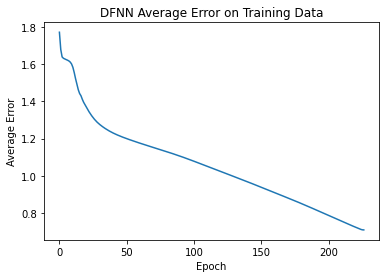

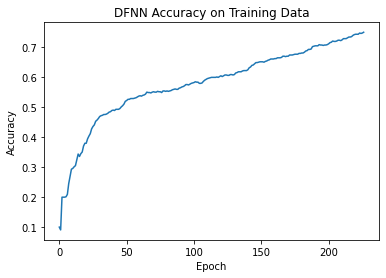

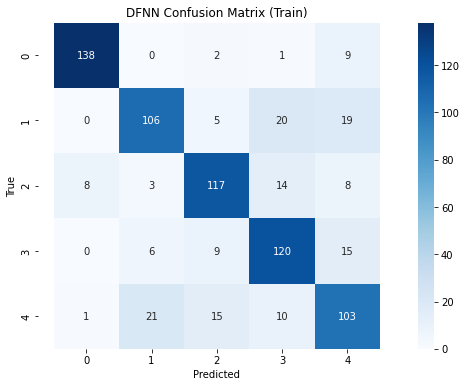

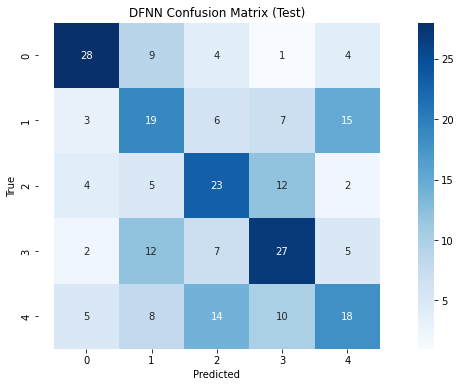

In [92]:
seed_all()

# (a) DFNN trained using only labeled data
dfnn = DFNN(input_dim, hidden_dims, output_dim)
dfnn_optimizer = optimizer_dfnn(dfnn.parameters(), lr=learning_rate)
dfnn_classifier = DFNNClassifier(dfnn, criterion_dfnn, dfnn_optimizer, epochs, threshold, batch_size)
dfnn_classifier.optimizer_name = "DFNN"
# train_errors, train_accuracies = dfnn_classifier.train(train_data_labeled, train_labels)
# dfnn_classifier.plot_avg_train_error(train_errors)
# dfnn_classifier.plot_avg_train_accuracy(train_accuracies)
# dfnn_classifier.confusion_matrix_train(train_data_labeled, train_labels)
# dfnn_classifier.confusion_matrix_test(test_data, test_labels)
dfnn_classifier.plot_all(train_data_labeled, train_labels, test_data, test_labels)


Autoencoder:   0%|          | 0/3 [00:00<?, ?it/s]

DFNN Training:  12%|█▎        | 125/1000 [00:03<00:25, 34.63epoch/s]


Converged at epoch 125
SAE Loss: 1.3603585958480835, Accuracy: 0.46, Epochs: 126


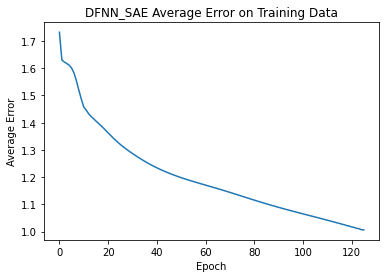

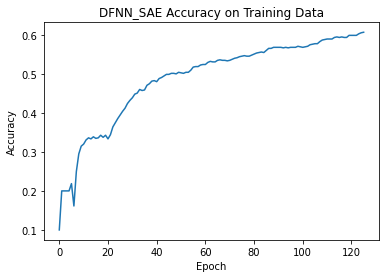

array([[29, 10,  6,  0,  1],
       [ 1, 16,  6, 16, 11],
       [ 4,  7, 21, 13,  1],
       [ 1,  7,  5, 35,  5],
       [ 4,  9, 14, 14, 14]], dtype=int64)

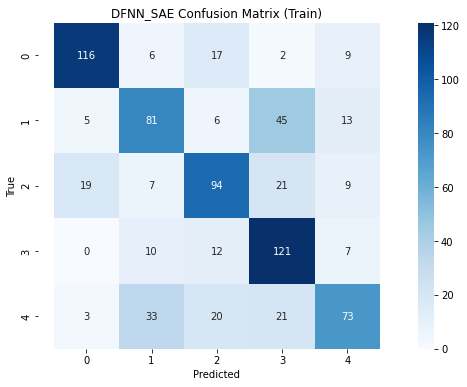

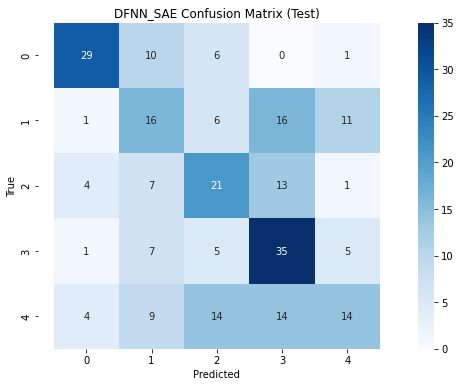

In [91]:
seed_all()
# (b) DFNN using a stacked autoencoder pretrained using unlabeled data and finetuned using labeled data
sae = StackedAutoEncoder(input_dim, hidden_dims)
sae_optimizer = optimizer_ae(sae.parameters(), lr=learning_rate)
dfnn = DFNN(input_dim, hidden_dims, output_dim)
dfnn_optimizer = optimizer_dfnn(dfnn.parameters(), lr=learning_rate)
dfnn_classifier = DFNNClassifier(dfnn, criterion_dfnn, dfnn_optimizer, epochs, threshold, batch_size)
dfnn_classifier.optimizer_name = "DFNN_SAE"
sae_classifier = SAEClassifier(sae, dfnn_classifier, criterion_ae, sae_optimizer, epochs, threshold, batch_size)
sae_classifier.optimizer_name = "SAE"
sae_classifier.pretrain_autoencoders(train_data_unlabeled)
train_errors, train_accuracies = sae_classifier.fine_tune_classifier(train_data_labeled, train_labels)
loss, accuracy, predictions = sae_classifier.evaluate(test_data, test_labels)
print(f"SAE Loss: {loss}, Accuracy: {accuracy}, Epochs: {len(train_errors)}")
sae_classifier.plot_avg_train_error(train_errors)
sae_classifier.plot_avg_train_accuracy(train_accuracies)
sae_classifier.confusion_matrix_train(train_data_labeled, train_labels)
sae_classifier.confusion_matrix_test(test_data, test_labels)

# sae_classifier.plot_all(train_data_unlabeled, train_data_labeled, train_labels, test_data, test_labels) # pretraining+finetuning+plots
